# Profile processing Step 3a: Looking at the grouped data 

There are two ways to look at and process the master dataset created in step 2, i.e. the file ```0_analysis_output/particle_profile_data.csv```. The first is to do it by groups identified in step 1 (what is done in this step 2a notebook) The second is to group the data by specified depth bins or particle number bins (what is done in the Step 3b notebook).

The group breakpoints used in this notebook are either 
1. no breakpoints at all (that is, process all the data into a single group); or 
2. through the use of the cast-specific user-identified breakpoints in step 1. These breaks may be locations where the camera was held steady at a given depth for some amount of time, or they may simply be groups of images for time or depth-averaged calculations. 

To look at the data, two primary types of input are needed. The first is just the path to the cast of interest. The second type of user input pertains to values needed to convert the particle data from pixel-based measurements to micron-based measurements and the development of particle size distribution statistics. 

Several types of files will be generated when running the cells of this notebook. The data types include:
- Summary statistics for each group ("ProcData_0_GroupSummary.csv")
- the time series data for each group ("ProcData_1_timeseries_GroupName.csv")
- the PDF or histogram of each group ("ProcData_2_PDF_GroupName.csv")
- the CDF of particle size for each group ("ProcData_2_CDF_GroupName.csv")
- Plot of the profile (ProcData_3_figure-GroupSummary.pdf)

In [1]:
%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display 
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
%matplotlib widget

In [8]:
""" --- User input ----------------------------- """

# folder/file paths
# lisstbins_file = '/Users/strom-adm/Floc-Processing/Code/LISST_bins/LISST_bins_random_ext.csv' # LISST bin data if used
lisstbins_file = '../LISST_bins/LISST_bins_random_ext.csv'

# user-set parameters for processing the data
muperpix = 0.925 # muperpix is the number of microns per per pixel (1.28 is equal to 800 pix per mm)
darea = 1 # use 1 to base particle size on area, 0 to base it on the minor axis of the fit elips
useLISST = 1  # use 1 if list bins sizes are to be used
vdist = 1 # use particle vol for distributions rather than the frequency weighting... if 1, then the w value below does not matter, if 0, w value is used
nb = 30
w = 3 # the distribution weighting value 0 = by number, 1 = by diameter (Ali's), 2 = by area, 3 = by vol

# inputs needed for mass concentration proxy
nf = 2.5 # floc fractal dimension
dp = 8   # primary particle size in micron
rhos = 2500 # density in kg/m3 of solid particles
image_vol = 10**-5 #(in liters)

"""  ------------------------------------------- """

# files to use... should not need to change
castpath = pd.read_csv('0_CastPath.csv').profile_path[0]+'/'
pdata_file = '0_analysis_output/particle_profile_data.csv' #dataframe with all of the particle data
breakpoint_file = 'Data-Breakpionts.csv'
depth_file = 'Depth.csv'

# read in the file
pdata = pd.read_csv(castpath+pdata_file)       
totaldepth = pd.read_csv(castpath+depth_file)['Depth [m]'][0]

# take a look at the break points

if(os.path.exists(castpath+breakpoint_file) == True):
    breakpoints = pd.read_csv(castpath+breakpoint_file)
    print("Here are the breakpoints in the profile.")
    display(breakpoints)
else:
    print('No breakpoint file found, will process all data as a single profile')

Here are the breakpoints in the profile.


,Type/Location,Start [DateTime],End [DateTime],Durration [sec]
0,surface,1.092021e+12,1.092021e+12,60
1,d1,1.092021e+12,1.092021e+12,138
2,d2,1.092021e+12,1.092021e+12,51
3,d3,1.092021e+12,1.092021e+12,53
4,d4,1.092021e+12,1.092021e+12,56
5,d5,1.092021e+12,1.092021e+12,21
6,d6,1.092021e+12,1.092021e+12,62
7,bottom,1.092021e+12,1.092021e+12,26
8,profile,1.092021e+12,1.092021e+12,146


## Look at a data snapshot from one of the data group types or locations listed in the breakpoint file

This step is not needed for processing. It's just here to allow for quick inspection of the data as desired.

In [9]:
""" --- User input ----------------------------- """
k = 1 # pick the index of the type/location you would like to look at
"""  ------------------------------------------- """

pdata_group = pdata[(pdata['Image Time'] >= breakpoints['Start [DateTime]'][k]) &
     (pdata['Image Time'] <= breakpoints['End [DateTime]'][k])].copy()

print('Location: ', breakpoints['Type/Location'][k]) 
print('- Distance off bed z [m] =',np.around(np.mean(pdata_group['z [m]']),decimals=2))
print('- Depth [m] =', np.around(np.mean(pdata_group['Depth [m]']),decimals=2))
print('- durration [sec]:',breakpoints['Durration [sec]'][k])
print('- number of unique images:', len(pdata_group['ImgNo'].unique())) 
print('- number of particles:', len(pdata_group['Number']))
display(pdata_group)
display(breakpoints) # display again to make it easy to select the breakpoints in the next step

Location:  d1
- Distance off bed z [m] = 11.79
- Depth [m] = 3.7
- durration [sec]: 138
- number of unique images: 140
- number of particles: 10773


,Number,ImgNo,NoInTot,Area,MeanGreyValue,StdDev,MinGreyValue,MaxGreyValue,Perimeter,BX,...,AR,Round,Solidity,Streak_impact,Image Time,z [m],Depth [m],T [Celsius],SpC [MicroSiemens/cm],PSU
4366,1,135,41573,462,53.751,23.246,5,122,92.912,40,...,2.005,0.499,0.857,0,1.092021e+12,11.809521,3.682257,8.403770,273.552271,0.192412
4367,13,135,41585,195,60.338,23.568,2,105,55.355,743,...,1.535,0.651,0.882,0,1.092021e+12,11.809521,3.682257,8.403770,273.552271,0.192412
4368,18,135,41590,174,59.713,25.015,1,117,67.113,3596,...,3.067,0.326,0.847,0,1.092021e+12,11.809521,3.682257,8.403770,273.552271,0.192412
4369,21,135,41593,301,51.033,25.431,4,113,71.012,564,...,1.399,0.715,0.871,0,1.092021e+12,11.809521,3.682257,8.403770,273.552271,0.192412
4370,22,135,41594,62,66.629,18.396,15,115,34.627,3030,...,1.580,0.633,0.790,0,1.092021e+12,11.809521,3.682257,8.403770,273.552271,0.192412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15134,302,303,105439,1630,39.903,19.531,0,100,189.480,2542,...,1.549,0.646,0.841,0,1.092021e+12,11.776307,3.715471,8.388464,273.381775,0.192242
15135,309,303,105446,20,67.900,27.201,9,104,16.728,351,...,1.421,0.704,0.816,0,1.092021e+12,11.776307,3.715471,8.388464,273.381775,0.192242
15136,317,303,105454,278,59.104,20.609,12,112,65.598,121,...,1.236,0.809,0.891,0,1.092021e+12,11.776307,3.715471,8.388464,273.381775,0.192242
15137,329,303,105466,2290,36.890,18.993,1,103,224.108,2025,...,1.803,0.555,0.846,0,1.092021e+12,11.776307,3.715471,8.388464,273.381775,0.192242


,Type/Location,Start [DateTime],End [DateTime],Durration [sec]
0,surface,1.092021e+12,1.092021e+12,60
1,d1,1.092021e+12,1.092021e+12,138
2,d2,1.092021e+12,1.092021e+12,51
3,d3,1.092021e+12,1.092021e+12,53
4,d4,1.092021e+12,1.092021e+12,56
5,d5,1.092021e+12,1.092021e+12,21
6,d6,1.092021e+12,1.092021e+12,62
7,bottom,1.092021e+12,1.092021e+12,26
8,profile,1.092021e+12,1.092021e+12,146


## Process and summarize an individual or set of subgroups

,Type/Location,Start [DateTime],End [DateTime],Durration [sec],Depth [m],z [m],PSU,Temp [C],Num. Images,Num. Particles,D16 [mu],D50 [mu],D84 [mu],D95 [mu],Total Vol [muL],C proxy [mg/L],Solidity_avg
0,surface,1.092021e+12,1.092021e+12,60,0.764552,14.727225,0.192684,8.474724,56.0,2094.0,38.945370,67.559280,118.254897,175.061002,0.053805,86.153146,0.835231
1,d1,1.092021e+12,1.092021e+12,138,3.699369,11.792408,0.192235,8.381052,140.0,10773.0,51.535226,96.292923,193.482464,295.872159,0.578238,312.944252,0.817197
2,d2,1.092021e+12,1.092021e+12,51,4.335105,11.156672,0.192257,8.388982,59.0,3187.0,54.078881,88.352688,145.462395,246.240900,0.227317,300.041243,0.835423
3,d3,1.092021e+12,1.092021e+12,53,6.691787,8.799991,0.192329,8.387105,62.0,3075.0,64.251336,109.129949,177.554089,227.313012,0.326572,375.771793,0.832827
4,d4,1.092021e+12,1.092021e+12,56,9.681741,5.810036,0.192351,8.384619,67.0,4114.0,65.184077,117.375088,213.810990,260.274018,0.461008,474.749047,0.826382
5,d5,1.092021e+12,1.092021e+12,21,10.365421,5.126356,0.192365,8.377623,19.0,2317.0,44.796367,75.721145,113.663269,151.069483,0.112175,507.660401,0.819558
6,d6,1.092021e+12,1.092021e+12,62,12.554197,2.937580,0.192383,8.371325,76.0,5742.0,58.218085,96.300404,159.821860,380.121895,0.652028,636.259552,0.824316
7,bottom,1.092021e+12,1.092021e+12,26,15.378757,0.113020,0.193032,8.359074,21.0,3658.0,55.487870,89.617940,135.028526,169.648696,0.380584,1412.705671,0.810914


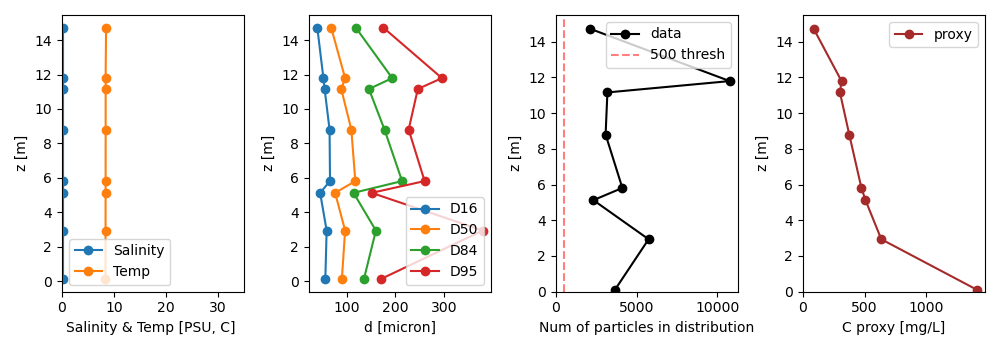

In [10]:
""" --- User input ----------------------------- """
summaryindexS = 0 # enter the index associated with the first group break to process
summaryindexE = 7 # enter the index associated with the last group break to process; 
                  # set summaryindexE = summaryindexS to process a single group
"""  ------------------------------------------- """

# start the summary table 

summary = breakpoints[summaryindexS:summaryindexE+1].copy()
summary.index = range(len(summary))

# setup summary arrays

N=len(summary)
depth = np.zeros(N)
zbed = np.zeros(N)
salinity = np.zeros(N)
temp = np.zeros(N)
numpart = np.zeros(N)
numimg = np.zeros(N)
d16 = np.zeros(N)
d50 = np.zeros(N)
d84 = np.zeros(N)
d95 = np.zeros(N)
d95 = np.zeros(N)
Vtotal = np.zeros(N)
Solidity = np.zeros(N)
Mass_per_image = np.zeros(N)

# pull the data and process for each group

for j in range(0,N):

    pdata_group = pdata[(pdata['Image Time'] >= summary['Start [DateTime]'][j]) &
         (pdata['Image Time'] <= summary['End [DateTime]'][j])].copy()
    
    pdata_group=pdata_group.drop(columns=['MeanGreyValue', 'StdDev', 'MinGreyValue', 'BX', 'BY',
                                         'Width','Height'])
    
    # set particle size and put in micron
    if(darea == 1):
        d = np.sqrt(4*(np.array(pdata_group.Area)*muperpix**2)/np.pi)
    else:
        d = np.array(pdata_group.Minor)
    
    pdata_group['D [mu]'] = d

    pdata_group.to_csv(castpath+'ProcData_1_timeseries-'+summary['Type/Location'][j]+'.csv',index=False)

    # pull easy averages for the group
    depth[j] = np.mean(pdata_group['Depth [m]'])
    zbed[j] = np.mean(pdata_group['z [m]'])
    salinity[j] = np.mean(pdata_group['PSU'])
    temp[j] = np.mean(pdata_group['T [Celsius]'])
    Solidity[j]= np.mean(pdata_group['Solidity'])
    
    # calculate the average particle mass per image in the group
    numimg[j] = int(len(pdata_group['ImgNo'].unique())) # find the unique number o fimages
    dvol_uL = 1e-9*(np.pi/6)*d**3 # volume of each particle in microliters (1 micron^3 = 1e-9 microliters)
    rhoa = rhos*(d/dp)**(nf-3) # apparent dry density of floc in kg/m3
    mass_mg = dvol_uL*rhoa*(1/1000) # mass (in mg) of each floc
    Mass_per_image[j] = np.sum(mass_mg)/numimg[j] # floc mass per image (averaged over the group)

    numpart[j]=int(len(d))

    if useLISST == 1:
        lisst_bins = pd.read_csv(lisstbins_file)
        edges = list(lisst_bins.Lower)
        edges.append(lisst_bins.Upper.iloc[-1])

    dlog=np.log(d)

    if vdist == 1:
        if useLISST == 1:
            values, base = np.histogram(d, bins=edges, weights=dvol_uL)
            number, base2 = np.histogram(d, bins=edges)
            centers = np.array(lisst_bins.Median)
            width = base[1:]-base[:-1]
        else:
            values, logbase = np.histogram(dlog, bins=nb, weights=dvol_uL)
            number, logbase2 = np.histogram(dlog, bins=nb)
            logcenters = (logbase[1:]+logbase[:-1])/2
            base = np.exp(logbase)
            width = base[1:]-base[:-1]
            centers = np.exp(logcenters)
        Vtotal[j]=sum(values)
    else:
        if useLISST == 1:
            values, base = np.histogram(d, bins=edges)
            number = values.copy()
            centers = np.array(lisst_bins.Median)
            width = base[1:]-base[:-1]
            values=values*(centers)**w
        else:
            values, logbase = np.histogram(dlog, bins=nb)
            number = values.copy()
            logcenters = (logbase[1:]+logbase[:-1])/2
            base = np.exp(logbase)
            width = base[1:]-base[:-1]
            centers = np.exp(logcenters)
            values=values*(centers)**w
    
    valuefrac = values/np.sum(values)
    pdf=pd.DataFrame({'d_mu':centers,'vol_or_freq':values,'fraction_total':valuefrac,'numb_particles':number})
    pdf.to_csv(castpath+'ProcData_2_PDF-'+summary['Type/Location'][j]+'.csv',index=False)
    
    cumulative = np.cumsum(values) # adds up the frequencies (total is the total number of points)
    perc = cumulative/cumulative[len(cumulative)-1]
    percfiner = perc
    percfiner = np.insert(percfiner,0,0)
    
    cdf=pd.DataFrame({'d_mu':base,'fracfiner':percfiner})
    cdf.to_csv(castpath+'ProcData_2_CDF-'+summary['Type/Location'][j]+'.csv',index=False)
    
    d16[j]=np.interp(0.16,percfiner,base)
    d50[j]=np.interp(0.5,percfiner,base)
    d84[j]=np.interp(0.84,percfiner,base)
    d95[j]=np.interp(0.95,percfiner,base)

# build the summary data table 

summary['Depth [m]']= depth
summary['z [m]'] = zbed
summary['PSU'] = salinity
summary['Temp [C]'] = temp
summary['Num. Images']=numimg
summary['Num. Particles']=numpart
summary['D16 [mu]']=d16
summary['D50 [mu]']=d50
summary['D84 [mu]']=d84
summary['D95 [mu]']=d95
summary['Total Vol [muL]']=Vtotal
summary['C proxy [mg/L]']=Mass_per_image/image_vol
summary['Solidity_avg']=Solidity
summary.to_csv(castpath+'ProcData_0_GroupSummary.csv',index=False)
display(summary)

# plot the data

# fig, (ax1, ax2) = plt.subplots(1,2,figsize=(6,4))
fig, (ax1, ax2, ax3,ax4) = plt.subplots(1,4,figsize=(10,3.5))
ax1.plot(summary['PSU'], summary['z [m]'],'-o', alpha=1,label='Salinity')
ax1.plot(summary['Temp [C]'], summary['z [m]'],'-o', alpha=1,label='Temp')
ax1.set_xlim(0,35)
ax1.set_ylabel('z [m]')
ax1.set_xlabel('Salinity & Temp [PSU, C] ')
ax1.legend(loc=3)

ax2.plot(summary['D16 [mu]'], summary['z [m]'], marker='o',alpha=1,label='D16')
ax2.plot(summary['D50 [mu]'], summary['z [m]'], marker='o',alpha=1,label='D50')
ax2.plot(summary['D84 [mu]'], summary['z [m]'], marker='o',alpha=1,label='D84')
ax2.plot(summary['D95 [mu]'], summary['z [m]'], marker='o',alpha=1,label='D95')
# ax3.axhline(y = 0, color = 'k', linestyle = '-', alpha=0.5, label='bed')
# ax3.axhline(y = totaldepth, color = 'b', linestyle = '--', label='water surface')
# ax2.set_xlim(10,500)
ax2.set_ylabel('z [m]')
ax2.set_xlabel('d [micron]')
ax2.legend()

ax3.plot(summary['Num. Particles'], summary['z [m]'], '-o',color='k',alpha=1,label='data')
ax3.axvline(x = 500, color = 'r', linestyle = '--', alpha=0.5, label='500 thresh')
ax3.set_ylim(0,totaldepth)
ax3.set_xlim(0,)
ax3.set_ylabel('z [m]')
ax3.set_xlabel('Num of particles in distribution')
ax3.legend()

ax4.plot(summary['C proxy [mg/L]'], summary['z [m]'], '-o',color='brown',alpha=1,label='proxy')
# ax4.axvline(x = 500, color = 'r', linestyle = '--', alpha=0.5, label='500 thresh')
ax4.set_ylim(0,totaldepth)
ax4.set_xlim(0,)
ax4.set_ylabel('z [m]')
ax4.set_xlabel('C proxy [mg/L]')
ax4.legend()

fig.tight_layout();
plt.savefig(castpath+'ProcData_3_figure-GroupSummary.pdf',bbox_inches="tight", pad_inches=0.005)